### import libraries

In [81]:
import pandas as pd
import numpy as np
 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

### download data

In [48]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
# !wget $data# 

In [49]:
df = pd.read_csv('car_fuel_efficiency.csv', sep=',')

df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


### EDA

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [51]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [52]:
cols_with_null= df.columns[df.isnull().sum()>0]

for col in cols_with_null:
    df[col] = df[col].fillna(0)

In [53]:
df.isnull().sum()>0

engine_displacement    False
num_cylinders          False
horsepower             False
vehicle_weight         False
acceleration           False
model_year             False
origin                 False
fuel_type              False
drivetrain             False
num_doors              False
fuel_efficiency_mpg    False
dtype: bool

In [54]:
df.describe().round()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,num_doors,fuel_efficiency_mpg
count,9704.0,9704.0,9704.0,9704.0,9704.0,9704.0,9704.0,9704.0
mean,200.0,4.0,139.0,3001.0,14.0,2011.0,-0.0,15.0
std,49.0,2.0,48.0,498.0,5.0,7.0,1.0,3.0
min,10.0,0.0,0.0,953.0,0.0,2000.0,-4.0,6.0
25%,170.0,2.0,124.0,2666.0,13.0,2006.0,-1.0,13.0
50%,200.0,4.0,146.0,2993.0,15.0,2012.0,0.0,15.0
75%,230.0,5.0,168.0,3335.0,16.0,2017.0,1.0,17.0
max,380.0,13.0,271.0,4739.0,24.0,2023.0,4.0,26.0


### Do train/validation/test split with 60%/20%/20% distribution

In [55]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  

In [56]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [57]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [58]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [59]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [60]:
dv = DictVectorizer(sparse=True)

In [61]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

### Question 1

In [62]:
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [63]:
importances = pd.Series(dt.feature_importances_, index=dv.get_feature_names_out())
print(importances[importances > 0])

vehicle_weight    1.0
dtype: float64


### Question 2

In [66]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.4595777223092726


### Question 3

In [67]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

n_estimators= 10  -->  RMSE=0.460
n_estimators= 20  -->  RMSE=0.454
n_estimators= 30  -->  RMSE=0.452
n_estimators= 40  -->  RMSE=0.449
n_estimators= 50  -->  RMSE=0.447
n_estimators= 60  -->  RMSE=0.445
n_estimators= 70  -->  RMSE=0.445
n_estimators= 80  -->  RMSE=0.445
n_estimators= 90  -->  RMSE=0.445
n_estimators=100  -->  RMSE=0.445
n_estimators=110  -->  RMSE=0.444
n_estimators=120  -->  RMSE=0.444
n_estimators=130  -->  RMSE=0.444
n_estimators=140  -->  RMSE=0.443
n_estimators=150  -->  RMSE=0.443
n_estimators=160  -->  RMSE=0.443
n_estimators=170  -->  RMSE=0.443
n_estimators=180  -->  RMSE=0.442
n_estimators=190  -->  RMSE=0.442
n_estimators=200  -->  RMSE=0.442


In [73]:
for n, rmse in scores:
    print(f"n_estimators={n:3d}  -->  RMSE={rmse:.3f}")

n_estimators= 10  -->  RMSE=0.460
n_estimators= 20  -->  RMSE=0.454
n_estimators= 30  -->  RMSE=0.452
n_estimators= 40  -->  RMSE=0.449
n_estimators= 50  -->  RMSE=0.447
n_estimators= 60  -->  RMSE=0.445
n_estimators= 70  -->  RMSE=0.445
n_estimators= 80  -->  RMSE=0.445
n_estimators= 90  -->  RMSE=0.445
n_estimators=100  -->  RMSE=0.445
n_estimators=110  -->  RMSE=0.444
n_estimators=120  -->  RMSE=0.444
n_estimators=130  -->  RMSE=0.444
n_estimators=140  -->  RMSE=0.443
n_estimators=150  -->  RMSE=0.443
n_estimators=160  -->  RMSE=0.443
n_estimators=170  -->  RMSE=0.443
n_estimators=180  -->  RMSE=0.442
n_estimators=190  -->  RMSE=0.442
n_estimators=200  -->  RMSE=0.442


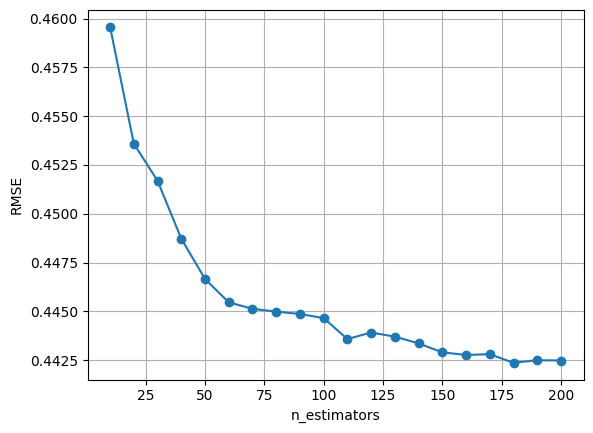

In [72]:
n_values = [n for n, _ in scores]
rmse_values = [rmse for _, rmse in scores]

plt.plot(n_values, rmse_values, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

### Question 4

In [74]:
max_depths = [10, 15, 20, 25]
n_estimators_list = range(10, 201, 10)

results = {}

for max_depth in max_depths:
    rmses = []
    for n in n_estimators_list:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=max_depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
    results[max_depth] = np.mean(rmses)

In [79]:
for d, mean_rmse in results.items():
    print(f"max_depth={d} -> mean RMSE={mean_rmse:.4f}")

best_depth = min(results, key=results.get)
print(f"Best max_depth = {best_depth}")

max_depth=10 -> mean RMSE=0.4418
max_depth=15 -> mean RMSE=0.4454
max_depth=20 -> mean RMSE=0.4463
max_depth=25 -> mean RMSE=0.4459
Best max_depth = 10


### Question 5

In [80]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)


importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names_out())
importances = importances.sort_values(ascending=False)


print(importances.head(10))


vehicle_weight         0.959150
horsepower             0.015998
acceleration           0.011480
engine_displacement    0.003273
model_year             0.003212
num_cylinders          0.002343
num_doors              0.001635
origin=USA             0.000540
origin=Europe          0.000519
origin=Asia            0.000462
dtype: float64


### Question 6

In [82]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features.tolist())

In [83]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

### eta = 0.3

In [87]:

xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'reg:squarederror',
 
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=100)

[0]	train-rmse:1.81393	eval-rmse:1.85444
[5]	train-rmse:0.51381	eval-rmse:0.55664
[10]	train-rmse:0.37115	eval-rmse:0.43896
[15]	train-rmse:0.34666	eval-rmse:0.43362
[20]	train-rmse:0.33553	eval-rmse:0.43376
[25]	train-rmse:0.32268	eval-rmse:0.43683
[30]	train-rmse:0.31475	eval-rmse:0.43752
[35]	train-rmse:0.30960	eval-rmse:0.43784
[40]	train-rmse:0.30202	eval-rmse:0.43968


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:10:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbosty" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[45]	train-rmse:0.29126	eval-rmse:0.44024
[50]	train-rmse:0.28456	eval-rmse:0.44140
[55]	train-rmse:0.27618	eval-rmse:0.44225
[60]	train-rmse:0.26768	eval-rmse:0.44290
[65]	train-rmse:0.26174	eval-rmse:0.44352
[70]	train-rmse:0.25489	eval-rmse:0.44531
[75]	train-rmse:0.24792	eval-rmse:0.44628
[80]	train-rmse:0.24254	eval-rmse:0.44689
[85]	train-rmse:0.23644	eval-rmse:0.44749
[90]	train-rmse:0.23193	eval-rmse:0.44839
[95]	train-rmse:0.22475	eval-rmse:0.44904
[99]	train-rmse:0.21950	eval-rmse:0.45018


In [88]:
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("eta=0.3 RMSE:", rmse)


eta=0.3 RMSE: 0.45017755678087246


### eta = 0.1

In [89]:
xgb_params = {
    'eta':0.1,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'reg:squarederror',
 
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=100)

[0]	train-rmse:2.28944	eval-rmse:2.34561
[5]	train-rmse:1.41247	eval-rmse:1.44988
[10]	train-rmse:0.91008	eval-rmse:0.94062
[15]	train-rmse:0.63402	eval-rmse:0.66672
[20]	train-rmse:0.48983	eval-rmse:0.53064
[25]	train-rmse:0.41881	eval-rmse:0.46891
[30]	train-rmse:0.38342	eval-rmse:0.44289
[35]	train-rmse:0.36435	eval-rmse:0.43250
[40]	train-rmse:0.35343	eval-rmse:0.42746
[45]	train-rmse:0.34621	eval-rmse:0.42595
[50]	train-rmse:0.33998	eval-rmse:0.42498


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbosty" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[55]	train-rmse:0.33480	eval-rmse:0.42449
[60]	train-rmse:0.33054	eval-rmse:0.42456
[65]	train-rmse:0.32602	eval-rmse:0.42493
[70]	train-rmse:0.32202	eval-rmse:0.42503
[75]	train-rmse:0.31895	eval-rmse:0.42526
[80]	train-rmse:0.31667	eval-rmse:0.42563
[85]	train-rmse:0.31440	eval-rmse:0.42574
[90]	train-rmse:0.31059	eval-rmse:0.42586
[95]	train-rmse:0.30625	eval-rmse:0.42611
[99]	train-rmse:0.30419	eval-rmse:0.42623


In [90]:
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("eta=0.1 RMSE:", rmse)


eta=0.1 RMSE: 0.42622800553359225
